# Medium Articles Recommender System - Non-Negative Matrix Factorization
`Omar El Yousfi`

## Introduction:
In order to build medium articles recommender system, I will be using Non-Negative Matrix Factorization method to cluster articles with same topics. <br/>
Before building the ***Recommender System*** using NMF, I will have to perform some ***Natural Language Processing*** steps such as vectorizing data using TF-IDF. Also, it is important to perform ***Exploratory Data Analysis*** before diving into applying machine learning.<br/> 
Finally, I will sort the results based on number of claps (likes), because we want to recommend to readers good articles in the same topic that they are currently reading/interested in.

### Plan
1. Exploratory Data Analysis
2. Pre-Processing
3. Building Recommender System

### Libraries and Data Importation

In [1]:
# Basic Data Libraries
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# RegEx
import re

# Pre processing and NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF

In [2]:
plt.rcParams['figure.figsize'] = (8,6)

In [3]:
data = pd.read_csv("../input/medium-articles-dataset/medium_data.csv")
data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [4]:
data.iloc[1003].title

'<strong class="markup--strong markup--h3-strong">If You Learn to Write, You Can Change Your\xa0Life.</strong>'

## Exploratory Data Analysis

In every project, I like to start off by a sanity check using info method, to see if the data has any missing values and/or wrong data types:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6508 entries, 0 to 6507
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            6508 non-null   int64 
 1   url           6508 non-null   object
 2   title         6508 non-null   object
 3   subtitle      3479 non-null   object
 4   image         6361 non-null   object
 5   claps         6508 non-null   int64 
 6   responses     6508 non-null   object
 7   reading_time  6508 non-null   int64 
 8   publication   6508 non-null   object
 9   date          6508 non-null   object
dtypes: int64(3), object(7)
memory usage: 508.6+ KB


#### Data types
**responses:** This column needs to be an integer, after a quick check, I found out that the column contains a "Read" value, which needs to be dropped. <br/>
**date:** I do not plan to use date column, but it might be an option in the future to recommend only most recent articles, so I will be fixing this data type. 
#### Missing values
We can see that subtitle column has multiple missing values, which I will be treating in the pre processing section. Finally, image column has missing values too, but we won't be using to whatsoever, so it is okay to just drop it.

In [6]:
data["responses"].unique()

array(['8', '11', '1', '0', '3', '2', '60', '27', '58', '13', '6', '15',
       '5', '4', '19', '10', '9', '7', '16', '76', '33', '21', '28', '14',
       '24', '17', '78', '30', '12', '74', '50', '18', '22', '48', '26',
       '20', '35', '51', '25', '62', '53', '120', '41', 'Read', '34',
       '86', '82', '63', '46', '170', '45', '23', '32', '29', '52', '117'],
      dtype=object)

In [7]:
data[data["responses"]=="Read"]

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
3977,3978,https://medium.com/datadriveninvestor/what-do-...,What do you think of the Open Group’s Data Sci...,NaN,3978.jpg,73,Read,3,Data Driven Investor,2019-05-24
6392,6393,https://uxdesign.cc/please-please-please-tell-...,"UX doesn’t discriminate, it targets behaviours",NaN,NaN,74,Read,5,UX Collective,2019-12-05


In [8]:
data.describe(include=object).T.style.background_gradient(subset=["count"], cmap="Greens")

,count,unique,top,freq
url,6508,6508,https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92,1
title,6508,6504,Lost in translation,2
subtitle,3479,3470,"A weekly selection of design links, brought to you by your friends at the UX Collective.",5
image,6361,6361,1.png,1
responses,6508,56,0,3396
publication,6508,7,The Startup,3041
date,6508,50,2019-10-21,197


We can see that "The Startup" is the most frequent publication in our dataset, 21th of octobre 2019 had the most number of articles. We can also see that 52% of articles did not have any reponses.

In [9]:
data.describe().T.style.background_gradient(cmap='PuBu')

,count,mean,std,min,25%,50%,75%,max
id,6508.000000,3254.500000,1878.842108,1.000000,1627.750000,3254.500000,4881.250000,6508.000000
claps,6508.000000,311.076060,950.789896,0.000000,54.000000,115.000000,268.250000,38000.000000
reading_time,6508.000000,6.134911,3.231918,0.000000,4.000000,5.000000,7.000000,55.000000


Looking at this summary statistics, we can see that the average reading time is 6 minutes, while we can find an article that has a reading time of 55 minutes! Whoever is reading that article deserves a medal. From the mean and median, it looks like the reading time column is normally distributed, but is it? I like to check for distribution type using Emperical Cumulative Distribution Function (ECDF). <br/>
**PS:** You can use ecdfplot of seaborn instead of creating a manual visualization.

In [10]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

What I usually do is plot ecdf of our column, alongside a a theoritcal distribution using statistics of our column. In this example I will test if our data is normally distributed first, so I will use theoritcal sample using the mean and standard deviation of reading time column, and compare it to our ecdf.

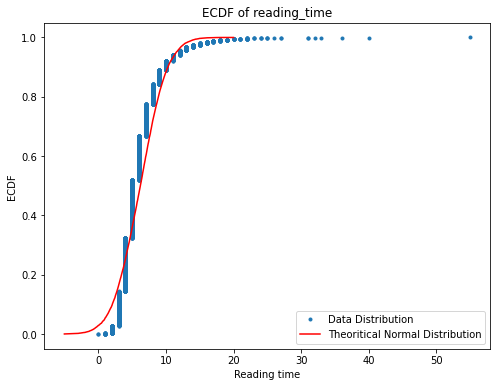

In [11]:
sample = np.random.normal(data["reading_time"].mean(), data["reading_time"].std(), size=10000)

x, y = ecdf(data["reading_time"])
x_theor, y_theor = ecdf(sample)

plt.plot(x, y, marker=".", linestyle="none", label="Data Distribution")
plt.plot(x_theor, y_theor, color="red", label="Theoritical Normal Distribution")

# ALWAYS LABEL PLOTS
plt.xlabel("Reading time")
plt.ylabel("ECDF")
plt.title("ECDF of reading_time")
plt.legend()

plt.show()

Another way to check if data is normally distributed, is performing Shapiro-Wilk test. We can perform the test using shapiro function of scipy.stats module

In [12]:
from scipy.stats import shapiro
shapiro(data["reading_time"])

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8009652495384216, pvalue=0.0)

From the plot we can tell that the data is not normally distributed, and the shapiro-wilk test approved our hypothesis since the p-value is 0.73 which is less than the threshold 0.05 (5%) then we fail to reject the null hypothesis. We do not have sufficient evidence to say that sample does come from a normal distribution.

Before testing other distributions, lets visualize histogram of the data:

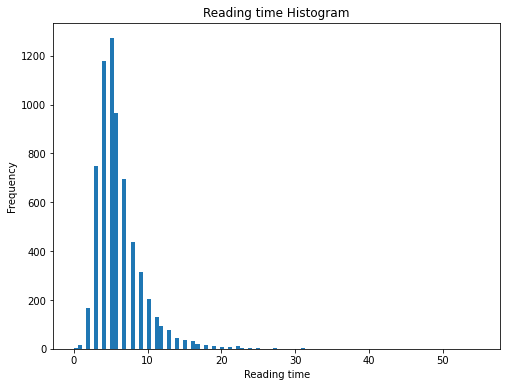

In [13]:
plt.hist(data["reading_time"], bins=100, stacked=True)

plt.title("Reading time Histogram")
plt.xlabel("Reading time")
plt.ylabel("Frequency")
plt.show()

First of all, data is obviously not normally distributed, also from the histogram we can see that reading time is a discrete variable *(Check following histogram for a comparaison between histograms of discrete and continous variables)*. For that reason, I will test poisson distribution.

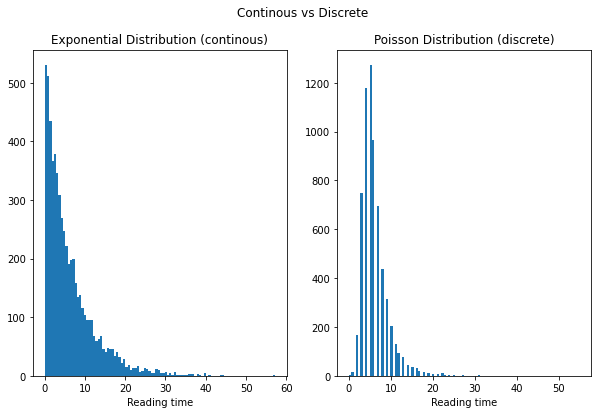

In [14]:
plt.figure(figsize=(10, 6))


plt.subplot(1, 2, 1)
plt.hist(np.random.exponential(data["reading_time"].mean(), size=6000), bins=100)
plt.title("Exponential Distribution (continous)")
plt.xlabel("Reading time")

plt.subplot(1, 2, 2)
plt.hist(data["reading_time"], bins = 100)
plt.title("Poisson Distribution (discrete)")
plt.xlabel("Reading time")

plt.suptitle("Continous vs Discrete")
plt.show()

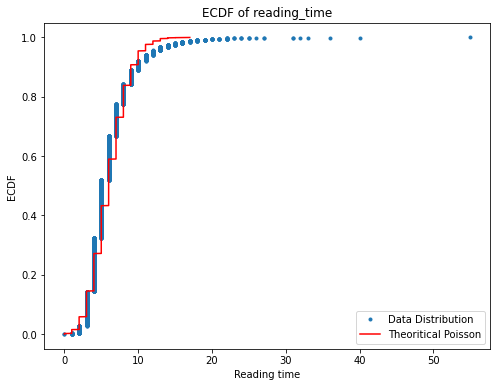

In [15]:
poisson = np.random.poisson(data["reading_time"].mean(), size=6000)

x_theor_po, y_theor_po = ecdf(poisson)

plt.plot(x, y, marker=".", linestyle="none", label="Data Distribution")
plt.plot(x_theor_po, y_theor_po, color="red", label="Theoritical Poisson")


# ALWAYS LABEL PLOTS
plt.xlabel("Reading time")
plt.ylabel("ECDF")
plt.title("ECDF of reading_time")
plt.legend()

plt.show()

We can conclude that reading_time is poisson distributed.

Difference between exponential distribution and poisson distirbution:
* Poisson is for discrete data and is based on arrivals or occurrence of events. Exponential talks about the time between occurrence of events and is a Continuous Probability Distribution Function. https://www.researchgate.net/post/QWhat_is_The_main_Difference_Between_Poisson_and_Exponential_Distributions

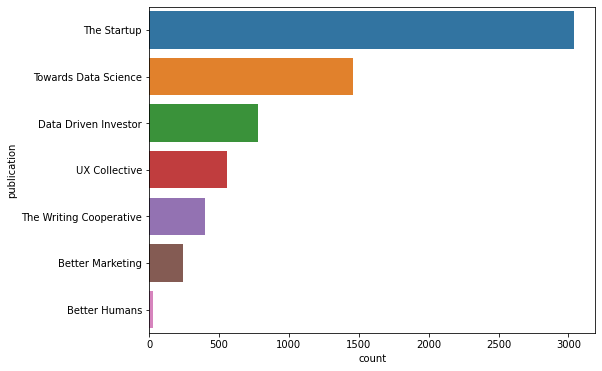

In [16]:
sns.countplot(y="publication", data=data, order=data['publication'].value_counts().index)
plt.show()

***The Startup*** is the publication most frequent in our data, followed by ***Towards Data Science.***

How does reading time vary in each publication?

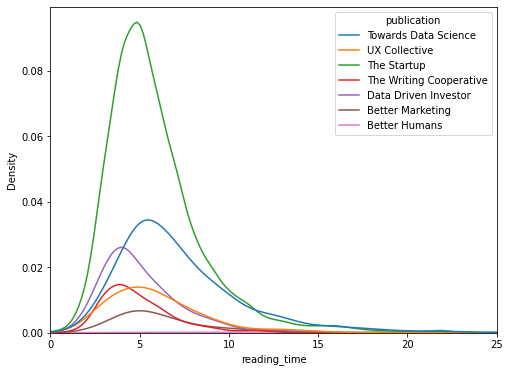

In [17]:
sns.kdeplot(x="reading_time", hue="publication", data=data)
plt.xlim(0,25)
plt.show()

From this kde plot we can see that the mean reading time does not differ much between publications.

Finally, to visualize relationship between reponses and claps, I have to first drop the articles that have responses as "Read" and convert the column type to int.

In [18]:
data[data["responses"]=="Read"]

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
3977,3978,https://medium.com/datadriveninvestor/what-do-...,What do you think of the Open Group’s Data Sci...,NaN,3978.jpg,73,Read,3,Data Driven Investor,2019-05-24
6392,6393,https://uxdesign.cc/please-please-please-tell-...,"UX doesn’t discriminate, it targets behaviours",NaN,NaN,74,Read,5,UX Collective,2019-12-05


In [19]:
data.drop(index=[3977, 6392], inplace=True)

In [20]:
data["responses"] = data["responses"].astype(int)
data["responses"].dtype

dtype('int64')

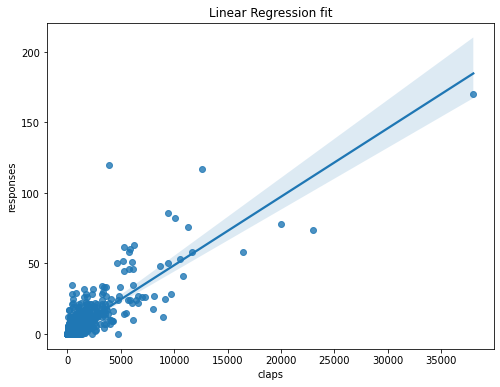

In [21]:
sns.regplot(x="claps", y="responses", data=data)
plt.title("Linear Regression fit")
plt.show()

It is obvious that articles with more claps get more responses, we can make sure of that plotting a correlation heatmap.

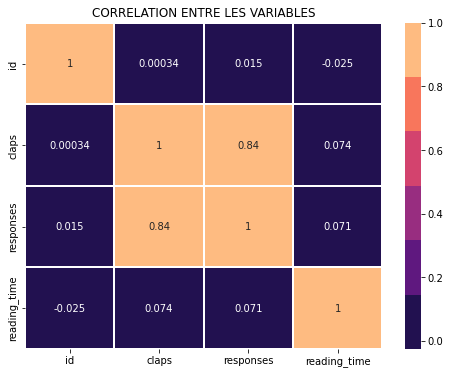

In [22]:
correlation = data.corr()
sns.heatmap(correlation,annot=True,
            cmap=sns.color_palette("magma"),
            linewidth=2,edgecolor="k")
plt.title("CORRELATION ENTRE LES VARIABLES")
plt.show()

reponses and claps are positvely correlated. (=0.84)

## Pre Processing

I will start by converting date column to its correct type:

In [23]:
data = data.astype({'date': 'datetime64[ns]'})
data["date"].dtype

dtype('<M8[ns]')

Next, I have noticed some titles that have html tags attached to them, I will applying some regex to delete those elements.
Example of a title with html element:

In [24]:
data.iloc[1003].title

'<strong class="markup--strong markup--h3-strong">If You Learn to Write, You Can Change Your\xa0Life.</strong>'

In [25]:
def fix_titles(row):
    if re.search("<\w.*?>", row) != None:
        data["title"] = data["title"].replace("<\w.*?>", "", regex=True)
        data["title"] = data["title"].replace("</\w.*?>", "", regex=True)
    return row

data['title'] = data['title'].apply(fix_titles)

Now I can drop columns that I won't be using: (not important step)

In [26]:
data.drop(columns=["id", "image"], inplace=True)

As I mentioned in the beginning, there are articles that do not have subtitles, so I will fill these missing subtitles with the title of the article.

In [27]:
data["subtitle"].fillna(data["title"], inplace=True)

A recommender system would be better if the data contained the whole body, or a summary of it, but since we do not have here, we can combined title and subtitle to form a column that we will apply NMF on.

In [28]:
data["article"] = data["title"] + data["subtitle"]
data.head()

,url,title,subtitle,claps,responses,reading_time,publication,date,article
0,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,A Beginner’s Guide to Word Embedding with Gens...,850,8,8,Towards Data Science,2019-05-30,A Beginner’s Guide to Word Embedding with Gens...
1,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,Hands-on Graph Neural Networks with PyTorch & ...,1100,11,9,Towards Data Science,2019-05-30,Hands-on Graph Neural Networks with PyTorch & ...
2,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,767,1,5,Towards Data Science,2019-05-30,How to Use ggplot2 in PythonA Grammar of Graph...
3,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,354,0,4,Towards Data Science,2019-05-30,Databricks: How to Save Files in CSV on Your L...
4,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,211,3,4,Towards Data Science,2019-05-30,A Step-by-Step Implementation of Gradient Desc...


Lets sort data by number of claps.

In [29]:
data = data.sort_values(by="claps", ascending=False)

Now, we have to vectorize the articles using **Tf-IDF** vecotizer.

In [30]:
vectorizer = TfidfVectorizer()
articles = vectorizer.fit_transform(data["article"])
articles

<6506x13730 sparse matrix of type '<class 'numpy.float64'>'
	with 73717 stored elements in Compressed Sparse Row format>

## Recommender System

Now we can apply NMF on our data and create the recommender. I choose 10 as number of components.

In [31]:
model = NMF(n_components=10, random_state=0)
nmf_features = model.fit_transform(articles)
model.components_

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.22218394e-02, 0.00000000e+00, ...,
        0.00000000e+00, 7.19719005e-03, 0.00000000e+00],
       [2.42439213e-03, 1.08082605e-03, 0.00000000e+00, ...,
        6.58950377e-04, 2.94480676e-03, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 8.48286416e-04, ...,
        0.00000000e+00, 0.00000000e+00, 1.92588173e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.84522087e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.76694948e-03, 8.72262060e-05, ...,
        0.00000000e+00, 1.19255427e-03, 2.85078158e-03]])

Now I will normalize nmf features to a unit norm.

In [32]:
normalized = normalize(nmf_features)

### Results

To make it easy to work with the features, lets create a dataframe containing the features, indexed by title of article.

In [33]:
df = pd.DataFrame(data=normalized, index=data["title"])

The resulted dataframe:

In [34]:
df.sample(10)

,0,1,2,3,4,5,6,7,8,9
title,,,,,,,,,,
How I Made $100 on Medium in My Second Month,0.000000,0.150669,0.047917,0.000000,0.000000,0.011990,0.000000,0.329366,0.040758,0.929901
Best Practices for NLP Classification in TensorFlow 2.0,0.000496,0.000000,0.000000,0.000000,0.550908,0.000000,0.649373,0.000000,0.000000,0.524228
Why I'm switching back to a career in Tech?…… Data Science,0.002224,0.295432,0.000000,0.000000,0.879983,0.000000,0.000000,0.033397,0.000000,0.370446
How We Consume Stories,0.000000,0.667693,0.045402,0.161885,0.000000,0.000000,0.000000,0.577125,0.000000,0.439140
Where The Wild Words Are,0.000000,0.422972,0.383709,0.000000,0.000000,0.000000,0.000000,0.000000,0.689624,0.445287
Building a model? Here’s the first question you should ask,0.000000,0.294832,0.251997,0.000000,0.000000,0.541981,0.248165,0.425836,0.559381,0.000000
What Are Ethical Hackers?,0.002894,0.000000,0.027589,0.007482,0.000000,0.504484,0.000000,0.860523,0.000000,0.064578
Why I changed my mind in purchasing Vietnam property,0.000902,0.000000,0.001970,0.000000,0.000000,0.006832,0.000000,0.213049,0.023549,0.976731
Differentiable Inter Agent Learning to Solve the Prisoners-Switch Riddle,0.000000,0.323564,0.330406,0.000000,0.000000,0.000000,0.886644,0.000000,0.000000,0.000000


Now lets say I am currently reading "Will AI steal UX/UI designers’ job?" article, which articles will the recommender suggest?

In [35]:
current = df.loc["Will AI steal UX/UI designers’ job?"]

Calculate similarites using Cosine Similarity.

In [36]:
similarities = df.dot(current)

I will merge the original dataframe with the resulted dataframe in order to sort by number of claps.

In [37]:
sims = pd.DataFrame(similarities.nlargest(10))
sims = sims.merge(data[["title", "claps"]], how='inner', on="title")
sims.set_index("title", drop=True, inplace=True)
sims.sort_values(by="claps", ascending=False).head()

,0,claps
title,,
Live Prediction of Traffic Accident Risks Using Machine Learning and Google Maps,0.983529,716
How Machine Learning Made Me Fall in Love with the WNBA,0.993950,304
Will AI steal UX/UI designers’ job?,1.000000,218
Predicting Unknown Unknowns,0.997026,142
"On Value Functions, Theory of Life and Bellmann Equation Gymnastics",0.996314,61


> Thank you for reading the notebook, let me know what you think about this approach in the comments.

`Omar El Yousfi`